In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/db_assignment"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/db_assignment


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from contractions import fix as contractions_fix
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
import string
import re
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.precision", 2)

# Ensure you have downloaded these nltk resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
df = pd.read_csv("./data/ubuntu_customer_msg_small.csv")

In [6]:
df.head()

,Unnamed: 0,raw_text
0,0,"Hello folks, please help me a bit with the following sentence: 'Order here your personal photos or videos.' - I think the only allowed version is 'Order your personal videos or photos here.', but I'm not sure, are you?"
1,1,is there any reason why my 'network manager' icon in my tray does not scale when the other ones get resized when i change the size of the panel?
2,2,"I installed the 64bit version of ubuntu and I can't open firefox(segfault) and if I try to open nautilus nothing happens and my cpu goes 100%, what can I do???"
3,3,Hello Does Ubuntu have somekind of register to configure applications and os settings?
4,4,anyone else run into issues with cd/dvd burners not identifying blank media installed?


In [7]:
df = df.drop(columns=["Unnamed: 0"], axis=1)
print(df.shape)

(185762, 1)


In [8]:
print(df.isnull().sum())

raw_text    0
dtype: int64


Basic Text cleaning function

In [10]:
def preprocess_text(text: str) -> str:
    """Preprocess the text"""
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Handle contractions
    text = contractions_fix(text)

    # Remove links
    text = re.sub(r"http\S+", "http-link", text)

    # Remove special characters and numbers
    text = re.sub(r"[^A-Za-z0-9\s/?/./']", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [
        word
        for word in tokens
        if word not in stop_words
        or word
        in [
            "what",
            "how",
            "why",
            "where",
            "do",
            "does",
            "did",
            "is",
            "does",
            "do",
            "can",
            "could",
            "would",
            "should",
            "not",
        ]
    ]

    # Reconstruct the text
    text = " ".join(tokens)

    return text

In [11]:
df["clean_text"] = df["raw_text"].parallel_apply(preprocess_text)

<ipython-input-10-6c4d41af8d1b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-10-6c4d41af8d1b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-10-6c4d41af8d1b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-10-6c4d41af8d1b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-inp

In [12]:
print(df.shape)
print(df.isnull().sum())

(185762, 2)
raw_text      0
clean_text    0
dtype: int64


In [15]:
sample = df.sample(100).reset_index(drop=True)
print(sample.shape)

(100, 2)


In [16]:
from sentence_transformers import SentenceTransformer

In [17]:
model_st3 = SentenceTransformer("paraphrase-mpnet-base-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
model_st1 = SentenceTransformer("all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
all_intents = df["clean_text"].tolist()
print(len(all_intents))

185762


In [27]:
# Start the multi-process pool on all available CUDA devices
pool = model_st1.start_multi_process_pool()

# Compute the embeddings using the multi-process pool
emb = model_st1.encode_multi_process(all_intents, pool)
print("Embeddings computed. Shape:", emb.shape)

# Optional: Stop the processes in the pool
model_st1.stop_multi_process_pool(pool)

Embeddings computed. Shape: (185762, 768)


In [28]:
X_cluster_df = np.vstack(emb)
print(X_cluster_df.shape)

(185762, 768)


In [47]:
def cluster_embeddings(embeddings, num_clusters):
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(normalized_embeddings)
    cls_dist = pd.Series(kmeans.labels_).value_counts()
    final_labels = kmeans.labels_ + 1
    return clusters, kmeans, cls_dist, final_labels

In [48]:
def evaluate_clustering(embeddings, clusters):
    silhouette_avg = silhouette_score(embeddings, clusters)
    return silhouette_avg

In [51]:
# cluster_labels = {}
# for i in range(5, 8):
#     clusters, kmeans, cls_dist, final_labels = cluster_embeddings(X_cluster_df, i)
#     silhouette_avg = evaluate_clustering(X_cluster_df, clusters)
#     print(f"Clusters: {i}, Silhouette Score: {silhouette_avg}")
#     cluster_labels[i] = {
#         "final_labels": final_labels,
#         "silhouette": silhouette_avg,
#         "cls_dist": cls_dist,
#     }

In [68]:
clusters, kmeans, cls_dist, final_labels = cluster_embeddings(X_cluster_df, 6)

In [75]:
pd.Series(final_labels).value_counts()

1    44175
5    35296
3    33673
2    28442
6    24943
4    19233
dtype: int64

In [70]:
import umap
import scipy

In [71]:
umap_embeddings = umap.UMAP(
    n_neighbors=15, n_components=2, metric="cosine"
).fit_transform(X_cluster_df)

In [72]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_, X_cluster_df)
centers = {}
print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
for i, d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i + 1] = ind
    print(i, cls_dist[i], ind, all_intents[ind], sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		44175		181576		does anyone know similar app amarok gnome ?
1		28442		117155		seems many programs ubuntu 's repository outdated
2		33673		53866		do correct drivers gfx card would check messing xorg.conf
3		19233		157857		try 'sudo iwconfig key restricted ' ... 'sudo dhclient '
4		35296		89998		is operating system drives ubuntu installation chrashed .
5		24943		9578		how do get permission write disk mounted ?


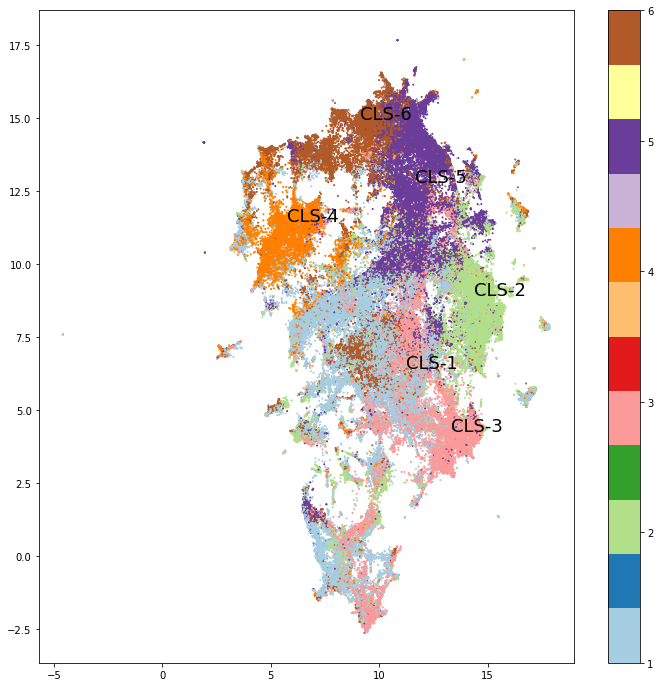

In [73]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(
    umap_embeddings[:, 0], umap_embeddings[:, 1], c=final_labels, s=1, cmap="Paired"
)
for c in centers:
    plt.text(
        umap_embeddings[centers[c], 0],
        umap_embeddings[centers[c], 1],
        "CLS-" + str(c),
        fontsize=18,
    )
plt.colorbar()